In [4]:
import tensorflow as tf

In [2]:
# Tensors
x = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
print(x,'\n')
print(x.shape, '\n')
print(x.dtype)

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32) 

(2, 3) 

<dtype: 'float32'>


In [3]:
print(x+x)
print(x * 5)
print(x @ tf.transpose(x))
print(tf.concat([x,x,x], axis=0))
print(tf.concat([x,x,x], axis=1))
print(tf.nn.softmax(x, axis=1))
print(tf.reduce_sum(x))

tf.Tensor(
[[ 2.  4.  6.]
 [ 8. 10. 12.]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[ 5. 10. 15.]
 [20. 25. 30.]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[14. 32.]
 [32. 77.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]
 [1. 2. 3.]
 [4. 5. 6.]
 [1. 2. 3.]
 [4. 5. 6.]], shape=(6, 3), dtype=float32)
tf.Tensor(
[[1. 2. 3. 1. 2. 3. 1. 2. 3.]
 [4. 5. 6. 4. 5. 6. 4. 5. 6.]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09003057 0.24472848 0.6652409 ]
 [0.09003057 0.24472848 0.6652409 ]], shape=(2, 3), dtype=float32)
tf.Tensor(21.0, shape=(), dtype=float32)


In [4]:
var = tf.Variable([0.0, 0.0, 0.0])
var.assign([1,2,3])
var.assign_add([1,1,1])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([2., 3., 4.], dtype=float32)>

In [8]:
x1 = tf.Variable(1.0)

def f(x):
    y = x**2 + 2*x - 5
    return y

print(f(x1))

tf.Tensor(-2.0, shape=(), dtype=float32)


In [9]:
with tf.GradientTape() as tape:
    y = f(x1)

g_x = tape.gradient(y, x1)
print(g_x)

tf.Tensor(4.0, shape=(), dtype=float32)


In [7]:
@tf.function
def my_func(x):
    print("tracing...\n")
    return tf.reduce_sum(x)


# with tf.function, functions will be creating graphs. (we call it 'capturing' graphs)
# non-tensorflow operations will be ignored after 2 or more function calls.
x = tf.constant([1.0, 2.0, 3.0])
print(my_func(x))
x = tf.constant([10.0, 9.0, 8.0])
print(my_func(x))
x = tf.constant([20.0, 7.0, 4.0])
print(my_func(x), '\n')

# with different signatures(shape, dtype), new graph will be created, thus print() is called again

x = tf.constant([10, 9, 8], dtype=tf.int32)
print(my_func(x))

tracing...

tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(27.0, shape=(), dtype=float32)
tf.Tensor(31.0, shape=(), dtype=float32) 

tracing...

tf.Tensor(27, shape=(), dtype=int32)


In [8]:
# tf.Module is a class for managing tf.Variable objects and tf.functions objects
# tf.Module class is necessary to support two significant features.

# 1. we can save and restore values of variables using tf.train.Checkpoint
# 2. we can import and export tf.variables and tf.function graphs using tf.saved_model

# simple tf.Module object example

class MyModule(tf.Module):
    def __init__(self, value):
        self.weight = tf.Variable(value)

    @tf.function
    def multiply(self, x):
        return x * self.weight

mod = MyModule(3)
mod.multiply(tf.constant([1,2,3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9])>

In [9]:
# resulting SavedModel is independent to python

# save_path = './saved'
# tf.saved_model.save(mod, save_path)

# reloaded = tf.saved_model.load(save_path)
# reloaded.multiply(tf.constant([1,2,3])

# tf.keras.layers.Layer
# tf.keras.Model            => both built on tf.Module class

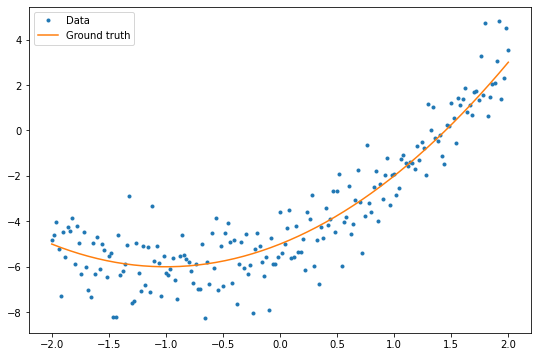

In [10]:
# training loops
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9,6]
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
    y = x**2 + 2*x - 5
    return y

y = f(x) + tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x),label='Ground truth')
plt.legend()

In [11]:
class MyModel(tf.keras.Model):
    def __init__(self, units):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(units=units, activation=tf.nn.relu,
                                            kernel_initializer=tf.random.normal, bias_initializer=tf.random.normal)
        self.dense2 = tf.keras.layers.Dense(1)

    def call(self, x, training=True):
        x = x[:, tf.newaxis]
        x = self.dense1(x)
        x = self.dense2(x)
        return tf.squeeze(x, axis=1)

model = MyModel(64)

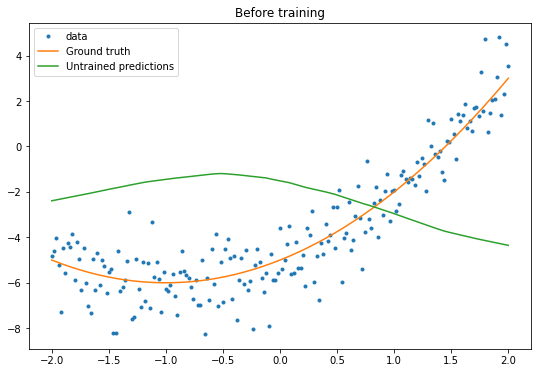

In [12]:
plt.plot(x.numpy(), y.numpy(), '.', label='data')
plt.plot(x, f(x), label='Ground truth')
plt.plot(x, model(x), label='Untrained predictions')
plt.title('Before training')
plt.legend()

In [14]:
# basic training loop

variables = model.variables
optimizer = tf.optimizers.SGD(lr=0.01)

for step in range(1000):
    with tf.GradientTape() as tape:
        prediction = model(x)
        error = (y-prediction)**2
        mean_error = tf.reduce_mean(error)
        # mean_error = tf.losses.MSE(y,prediction)
    gradient = tape.gradient(mean_error, variables)
    optimizer.apply_gradients(zip(gradient,variables))

    if step % 100 == 0:
        print(f'MSE : {mean_error.numpy():0.3f}')

C:\Users\dev\AppData\Roaming\Python\Python37\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


MSE : 1.092
MSE : 1.090
MSE : 1.089
MSE : 1.088
MSE : 1.088
MSE : 1.087
MSE : 1.086
MSE : 1.085
MSE : 1.085
MSE : 1.084


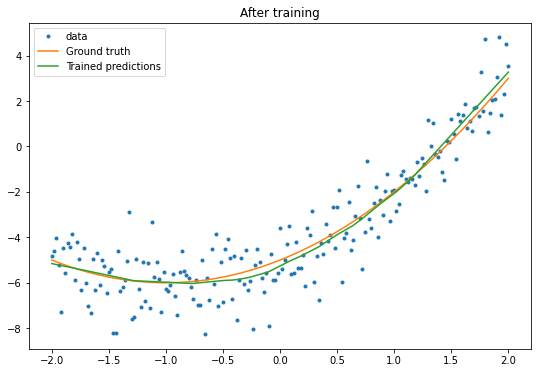

In [15]:
plt.plot(x.numpy(),y.numpy(), '.', label="data")
plt.plot(x, f(x),  label='Ground truth')
plt.plot(x, model(x), label='Trained predictions')
plt.title('After training')
plt.legend();

In [16]:
new_model = MyModel(64)

new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.optimizers.SGD(lr=0.01)
)

history = new_model.fit(x,y,epochs=100, batch_size=32,verbose=0)

C:\Users\dev\AppData\Roaming\Python\Python37\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Text(0.5, 1.0, 'Keras training')

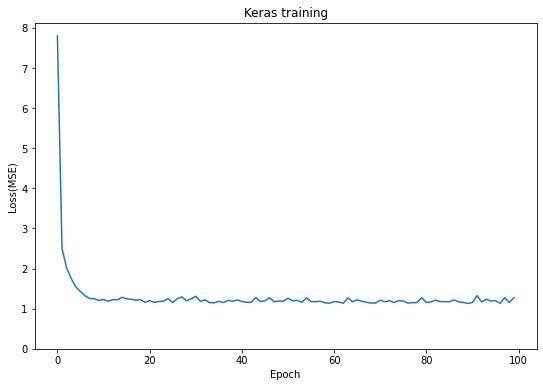

In [17]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss(MSE)')
plt.title('Keras training')